# Predict how long a trip will take
# Predict how much the trip will cost

- predicting duration in seconds
    - why is this useful???
    - SHIT, fees are restrospective features
    - if this were to be in production, which features do we feed our model??
- predicting fare amount a better problem???

- measure error with rmsle
- train with May 2019
- test with June 2019

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load data

In [60]:
df = pd.read_csv('datasets/green_tripdata_2019-05.csv', parse_dates=['lpep_pickup_datetime', 'lpep_dropoff_datetime'])
df = df[df.RatecodeID == 1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493058 entries, 0 to 504886
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               493058 non-null  int64         
 1   lpep_pickup_datetime   493058 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  493058 non-null  datetime64[ns]
 3   store_and_fwd_flag     493058 non-null  object        
 4   RatecodeID             493058 non-null  int64         
 5   PULocationID           493058 non-null  int64         
 6   DOLocationID           493058 non-null  int64         
 7   passenger_count        493058 non-null  int64         
 8   trip_distance          493058 non-null  float64       
 9   fare_amount            493058 non-null  float64       
 10  extra                  493058 non-null  float64       
 11  mta_tax                493058 non-null  float64       
 12  tip_amount             493058 non-null  floa

In [61]:
LOCATION_LOOKUP = pd.read_csv('datasets/taxi+_zone_lookup.csv')
LOCATION_LOOKUP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


seems like there are some hidden nulls

# Look at features

- Pickup & drop off time
    - use these two features to derive our target variable = duration
    - can derive hour of the day that can be useful
- Location ID
    - can we tell much about these??
- RateCodeId
    - we'll look at 'Standard rate' only
    - other code will have different fees calculation
- fees related stuff should be correlated in some way, look to select only a few
    - fare_amount - calculated by meter
    - extra - 0.5 for rush hour and 1 for overnight (let's try to binarize these)
    - tip_amount - cash tips not included
    - tolls_amount - tools fee
    - mta_tax, improvement_surcharge --> constant
    - ehail_fee all null
    - congestion_surcharge - can this help indicate traffic

    - total_amount = total that customer paid except tips (can only use this for basic model)


- Discard some features
    - VendorID
        - let's assume that they all have similar drivers and release schedules
        - this may be an issue if some vendors have only night shifts = less traffic
    - store_and_fwd_code
        - purely about data submission
    - RateCodeId
        - we've already used this for filtering (we currently focus on Standard rate)
    - passenger_count
        - should have no influence on trip distance????????
    - mta_tax, improvement_surcharge
        - constant
    - tip_amount
        - remove because cash trips are not included in the data
    - payment type
    - trip_type
        - street hail or dispatch should not have influence on duration
        - duration is calculated from 

In [62]:
BASIC_MODEL = ['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_distance']

# Basic model

## Feature engineering
- derive target variable
- join location id to lookup table
    - and get borough name only??
    - will this help much??
- weekend binary
- rush hour, working hours, overnight bins

In [63]:
def get_pu_do_boroughs(df, location_lookup=LOCATION_LOOKUP):
    df_get_pu_borough = pd.merge(df, location_lookup, how='inner', left_on='PULocationID', right_on='LocationID').loc[:, list(df.columns)+['Borough']]
    df_get_pu_borough.rename(columns={'Borough':'PUBorough'}, inplace=True)

    df_get_do_borough = pd.merge(df_get_pu_borough, location_lookup, how='inner', left_on='DOLocationID', right_on='LocationID').loc[:, list(df_get_pu_borough.columns)+['Borough']]
    df_get_do_borough.rename(columns={'Borough':'DOBorough'}, inplace=True)

    return df_get_do_borough 


def feature_engineering(df):
    df = df.assign(trip_duration_min=(df.loc[:, 'lpep_dropoff_datetime'] - df.loc[:, 'lpep_pickup_datetime']).dt.seconds / 60)
    df = df.assign(trip_speed_mph=df.loc[:, 'trip_distance'] / df.loc[:, 'trip_duration_min'] * 60)
    
    df = get_pu_do_boroughs(df)
    # df.drop(['PULocationID', 'DOLocationID'], axis=1, inplace=True)

    df = df.assign(is_weekend=df.lpep_pickup_datetime.dt.dayofweek.isin([5,6]))
    df = df.assign(is_rush=df.lpep_pickup_datetime.dt.hour.isin(range(16,20+1)) & ~df.is_weekend)
    df = df.assign(is_overnight=df.lpep_pickup_datetime.dt.hour.isin(list(range(20,23+1)) + list(range(0,8+1))))

    return df

df = feature_engineering(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493058 entries, 0 to 493057
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               493058 non-null  int64         
 1   lpep_pickup_datetime   493058 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  493058 non-null  datetime64[ns]
 3   store_and_fwd_flag     493058 non-null  object        
 4   RatecodeID             493058 non-null  int64         
 5   PULocationID           493058 non-null  int64         
 6   DOLocationID           493058 non-null  int64         
 7   passenger_count        493058 non-null  int64         
 8   trip_distance          493058 non-null  float64       
 9   fare_amount            493058 non-null  float64       
 10  extra                  493058 non-null  float64       
 11  mta_tax                493058 non-null  float64       
 12  tip_amount             493058 non-null  floa

## EDA

In [64]:
df[df.trip_distance == 0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,trip_duration_min,trip_speed_mph,PUBorough,DOBorough,is_weekend,is_rush,is_overnight
906,1,2019-05-05 16:49:32,2019-05-05 16:57:59,N,1,41,42,2,0.0,6.5,...,2,1,0.0,8.450000,0.0,Manhattan,Manhattan,True,False,False
929,1,2019-05-05 18:48:28,2019-05-05 18:53:56,N,1,41,42,3,0.0,5.0,...,2,1,0.0,5.466667,0.0,Manhattan,Manhattan,True,False,False
1039,2,2019-05-06 19:04:21,2019-05-06 19:11:58,N,1,41,42,1,0.0,6.0,...,2,1,0.0,7.616667,0.0,Manhattan,Manhattan,False,True,False
1851,2,2019-05-11 20:52:35,2019-05-11 21:02:59,N,1,41,42,1,0.0,7.5,...,1,1,0.0,10.400000,0.0,Manhattan,Manhattan,True,False,True
2812,1,2019-05-17 19:58:25,2019-05-17 20:07:03,N,1,41,42,2,0.0,6.5,...,2,1,0.0,8.633333,0.0,Manhattan,Manhattan,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492945,1,2019-05-18 13:23:17,2019-05-18 14:52:49,N,1,61,46,1,0.0,60.2,...,1,1,0.0,89.533333,0.0,Brooklyn,Bronx,True,False,False
492981,1,2019-05-11 17:10:48,2019-05-11 17:27:20,N,1,184,46,1,0.0,65.2,...,1,1,0.0,16.533333,0.0,Bronx,Bronx,True,False,False
492983,1,2019-05-18 19:23:27,2019-05-18 19:24:09,N,1,46,46,1,0.0,55.2,...,1,1,0.0,0.700000,0.0,Bronx,Bronx,True,False,False
492985,1,2019-05-29 19:21:06,2019-05-29 19:25:45,N,1,46,46,1,0.0,65.2,...,1,1,0.0,4.650000,0.0,Bronx,Bronx,False,True,False


In [65]:
df[df.trip_duration_min == 0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,payment_type,trip_type,congestion_surcharge,trip_duration_min,trip_speed_mph,PUBorough,DOBorough,is_weekend,is_rush,is_overnight
7463,1,2019-05-19 20:33:09,2019-05-19 20:33:09,N,1,42,42,1,0.0,55.2,...,1,1,0.0,0.0,NaN,Manhattan,Manhattan,True,False,True
7652,1,2019-05-21 15:31:44,2019-05-21 15:31:44,N,1,42,42,1,0.0,2.5,...,2,1,0.0,0.0,NaN,Manhattan,Manhattan,False,False,False
27574,2,2019-05-04 23:20:04,2019-05-04 23:20:04,N,1,75,75,1,0.0,2.5,...,2,1,0.0,0.0,NaN,Manhattan,Manhattan,True,False,True
59969,1,2019-05-11 13:50:53,2019-05-11 13:50:53,N,1,41,41,1,0.7,5.5,...,2,1,0.0,0.0,inf,Manhattan,Manhattan,True,False,False
61498,1,2019-05-23 22:33:42,2019-05-23 22:33:42,N,1,41,41,1,1.1,6.0,...,1,1,0.0,0.0,inf,Manhattan,Manhattan,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429985,1,2019-05-02 08:18:26,2019-05-02 08:18:26,N,1,40,25,1,0.0,50.0,...,1,1,0.0,0.0,NaN,Brooklyn,Brooklyn,False,False,True
433771,2,2019-05-17 15:31:47,2019-05-17 15:31:47,N,1,215,215,1,0.0,-2.5,...,3,1,0.0,0.0,NaN,Queens,Queens,False,False,False
433772,2,2019-05-17 15:31:47,2019-05-17 15:31:47,N,1,215,215,1,0.0,2.5,...,2,1,0.0,0.0,NaN,Queens,Queens,False,False,False
465843,1,2019-05-18 11:39:35,2019-05-18 11:39:35,N,1,72,72,1,0.0,55.2,...,1,1,0.0,0.0,NaN,Brooklyn,Brooklyn,True,False,False


In [66]:
def remove_zero_distance_duration(df):
    '''
    remove zeros for trip_duration_min and trip_distance
    zeros seem like data record error
    '''
    return df[(df['trip_distance'] != 0) & (df['trip_duration_min'] != 0)]
def remove_outliers_distance_duration(df):
    '''
    remove outliers for trip_duration_min and trip_distance
    remove top values greater or less than 3 std
    '''
    trip_duration_min_mean, trip_duration_min_std = df['trip_duration_min'].mean(), df['trip_duration_min'].std()
    trip_duration_min_lower = trip_duration_min_mean - 3*trip_duration_min_std
    trip_duration_min_upper = trip_duration_min_mean + 3*trip_duration_min_std

    trip_distance_mean, trip_distance_std = df['trip_distance'].mean(), df['trip_distance'].std()
    trip_distance_lower = trip_distance_mean - 3*trip_distance_std
    trip_distance_upper = trip_distance_mean + 3*trip_distance_std

    return df[
        ((df['trip_duration_min'] < trip_duration_min_upper) & (df['trip_duration_min'] > trip_duration_min_lower)) & \
        ((df['trip_distance'] < trip_distance_upper) & (df['trip_distance'] > trip_distance_lower))
        ]


df = remove_outliers_distance_duration(remove_zero_distance_duration(df))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472660 entries, 0 to 493057
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               472660 non-null  int64         
 1   lpep_pickup_datetime   472660 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  472660 non-null  datetime64[ns]
 3   store_and_fwd_flag     472660 non-null  object        
 4   RatecodeID             472660 non-null  int64         
 5   PULocationID           472660 non-null  int64         
 6   DOLocationID           472660 non-null  int64         
 7   passenger_count        472660 non-null  int64         
 8   trip_distance          472660 non-null  float64       
 9   fare_amount            472660 non-null  float64       
 10  extra                  472660 non-null  float64       
 11  mta_tax                472660 non-null  float64       
 12  tip_amount             472660 non-null  floa

Text(0, 0.5, 'Trips')

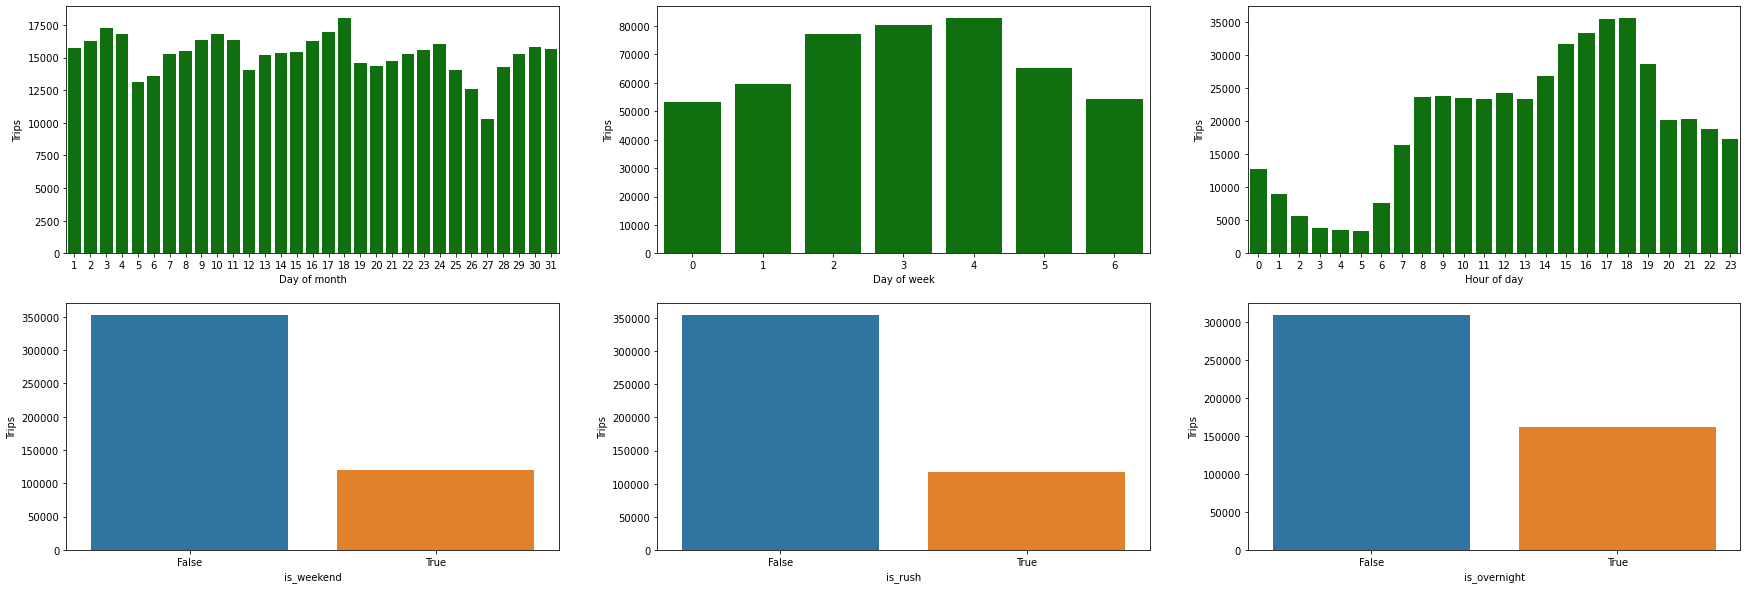

In [67]:
# number of trips by

plt.figure(figsize=(30,10))
# date of month (end of month people use cab more, or run out of money use subway haha)
plt.subplot(231)
sns.countplot(x=df.lpep_pickup_datetime.dt.day, color='green')
plt.xlabel('Day of month')
plt.ylabel('Trips')
# day of week
plt.subplot(232)
sns.countplot(x=df.lpep_pickup_datetime.dt.day_of_week, color='green')
plt.xlabel('Day of week')
plt.ylabel('Trips')
# hour of day
plt.subplot(233)
sns.countplot(x=df.lpep_pickup_datetime.dt.hour, color='green')
plt.xlabel('Hour of day')
plt.ylabel('Trips')

# weekdays and weekends
plt.subplot(234)
sns.countplot(x=df.is_weekend)
plt.ylabel('Trips')
# rush hour
plt.subplot(235)
sns.countplot(x=df.is_rush)
plt.ylabel('Trips')
# overnight
plt.subplot(236)
sns.countplot(x=df.is_overnight)
plt.ylabel('Trips')

<Figure size 1440x360 with 0 Axes>

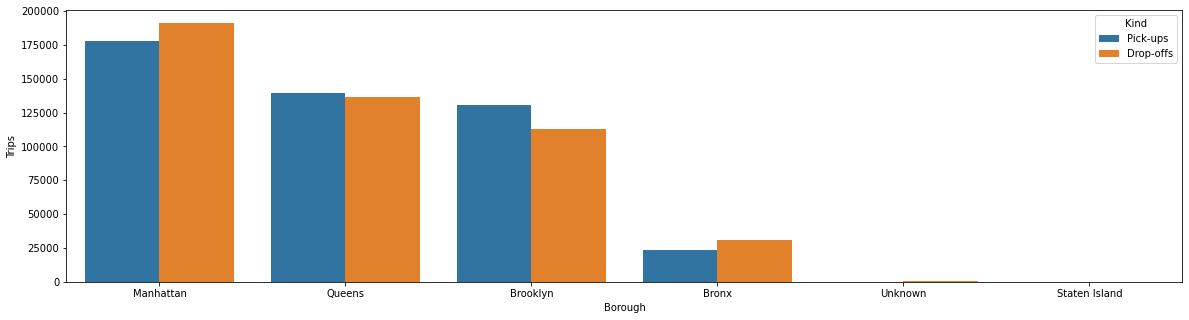

In [68]:
# Pickup and drop off location by boroughs
def plot_trips_by_locations(df):
    plt.figure(figsize=(20,5))

    pickups = df.PUBorough.value_counts().to_frame().reset_index()
    pickups.columns = ['Borough', 'Trips']
    pickups.loc[:,'Kind'] = 'Pick-ups'
    
    dropoffs = df.DOBorough.value_counts().to_frame().reset_index()
    dropoffs.columns = ['Borough', 'Trips']
    dropoffs.loc[:,'Kind'] = 'Drop-offs'
    
    combined = pd.concat([pickups, dropoffs], axis=0)

    plt.figure(figsize=(20,5))
    sns.barplot(data=combined, x='Borough', y='Trips', hue='Kind', estimator=np.sum)
    plt.show()

plot_trips_by_locations(df)

<AxesSubplot:xlabel='trip_duration_min'>

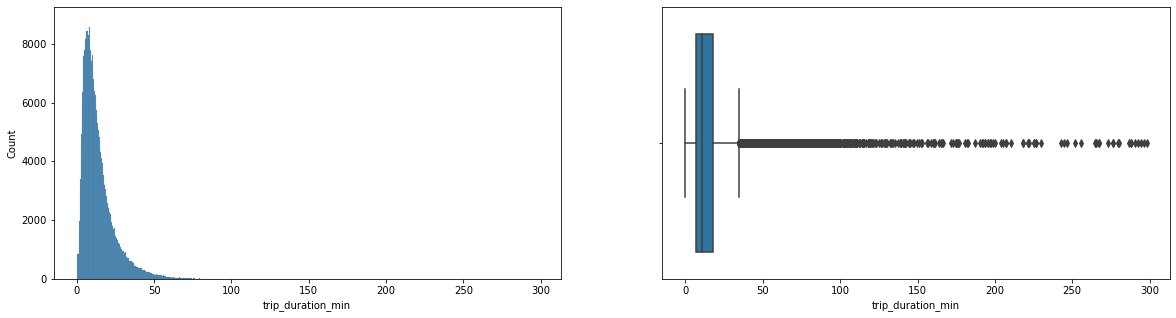

In [69]:
# trip duration distribution after removing zeros and outliers
plt.figure(figsize=(20,5))
plt.subplot(121); sns.histplot(data=df, x='trip_duration_min')
plt.subplot(122); sns.boxplot(data=df, x='trip_duration_min')

<AxesSubplot:xlabel='trip_distance'>

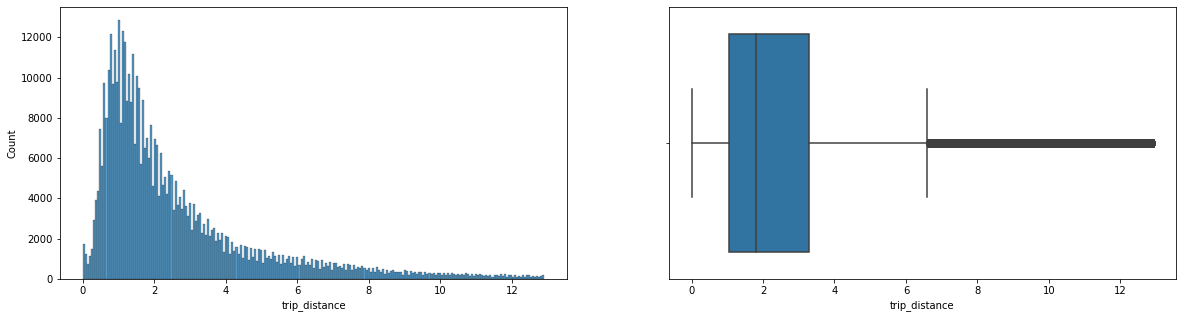

In [70]:
# trip distance after removing zeros and outliers
plt.figure(figsize=(20,5))
plt.subplot(121); sns.histplot(data=df, x='trip_distance')
plt.subplot(122); sns.boxplot(data=df, x='trip_distance')

Text(0, 0.5, 'Trip speed (miles per hour)')

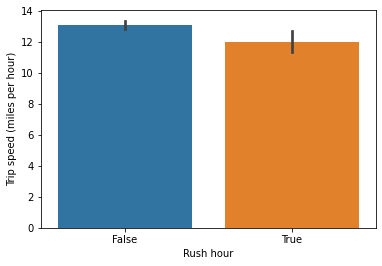

In [75]:
# trip speed by rush hour
sns.barplot(data=df, x='is_rush', y='trip_speed_mph')
plt.xlabel('Rush hour')
plt.ylabel('Trip speed (miles per hour)')

## Preprocessing pipeline
- work from df, this is the data format we will get

Steps
- train test split

- feature engineering
- remove zeros and outliers
- select feature

- scaling

In [17]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=9)

In [14]:
from sklearn.pipeline import Pipeline



,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance,trip_speed_mph,PUBorough,DOBorough,is_weekend,is_rush,is_overnight
0,2019-05-01 00:48:55,2019-05-01 00:55:07,1.50,14.516129,Manhattan,Manhattan,False,False,True
1,2019-05-01 00:04:22,2019-05-01 00:08:11,0.96,15.091703,Manhattan,Manhattan,False,False,True
2,2019-05-01 00:35:25,2019-05-01 00:37:52,0.73,17.877551,Manhattan,Manhattan,False,False,True
3,2019-05-01 00:30:29,2019-05-01 00:34:59,0.87,11.600000,Manhattan,Manhattan,False,False,True
4,2019-05-01 00:34:09,2019-05-01 00:38:12,1.07,15.851852,Manhattan,Manhattan,False,False,True
...,...,...,...,...,...,...,...,...,...
493039,2019-05-20 01:56:36,2019-05-20 02:08:42,1.85,9.173554,Staten Island,Staten Island,False,False,True
493043,2019-05-29 07:21:38,2019-05-29 07:56:34,5.10,8.759542,Staten Island,Staten Island,False,False,True
493044,2019-05-15 17:29:42,2019-05-15 17:56:04,7.20,16.384324,Brooklyn,Staten Island,False,True,False
493045,2019-05-07 17:59:57,2019-05-07 18:03:16,0.75,13.567839,Staten Island,Staten Island,False,True,False


## Fit basic model